# Cleaning US Census Data

## Inspect the Data

In [2]:
import zipfile
import pandas as pd
import os

# Unzipping the file
with zipfile.ZipFile('USCensus.zip', 'r') as zip_ref:
    zip_ref.extractall('USCensus')

# Get list of all files in the extracted folder
file_list = os.listdir('USCensus')

# Load the first CSV file into a DataFrame as an example
csv_file = [file for file in file_list if file.endswith('.csv')][0]  # Adjust to select the correct file if needed
df = pd.read_csv(f'USCensus/{csv_file}')

# Display the first few rows to inspect the data
print(df.head())

   CensusTract    State   County  TotalPop   Men  Women  Hispanic  White  \
0   1001020100  Alabama  Autauga      1948   940   1008       0.9   87.4   
1   1001020200  Alabama  Autauga      2156  1059   1097       0.8   40.4   
2   1001020300  Alabama  Autauga      2968  1364   1604       0.0   74.5   
3   1001020400  Alabama  Autauga      4423  2172   2251      10.5   82.8   
4   1001020500  Alabama  Autauga     10763  4922   5841       0.7   68.5   

   Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0    7.7     0.3  ...   0.5          2.3         2.1         25.0       943   
1   53.3     0.0  ...   0.0          0.7         0.0         23.4       753   
2   18.6     0.5  ...   0.0          0.0         2.5         19.6      1373   
3    3.7     1.6  ...   0.0          2.6         1.6         25.3      1782   
4   24.8     0.0  ...   0.0          0.6         0.9         24.8      5037   

   PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      74001 non-null  int64  
 1   State            74001 non-null  object 
 2   County           74001 non-null  object 
 3   TotalPop         74001 non-null  int64  
 4   Men              74001 non-null  int64  
 5   Women            74001 non-null  int64  
 6   Hispanic         73311 non-null  float64
 7   White            73311 non-null  float64
 8   Black            73311 non-null  float64
 9   Native           73311 non-null  float64
 10  Asian            73311 non-null  float64
 11  Pacific          73311 non-null  float64
 12  Citizen          74001 non-null  int64  
 13  Income           72901 non-null  float64
 14  IncomeErr        72901 non-null  float64
 15  IncomePerCap     73261 non-null  float64
 16  IncomePerCapErr  73261 non-null  float64
 17  Poverty     

In [ ]:
# Interpretation

# Missing Values: Some columns like Hispanic, Income, and Unemployment have missing values (nulls). You may want to handle these missing values before plotting.
# You can either remove rows with missing values or fill them with a relevant statistic (mean, median, etc.) depending on the analysis.

# Data Types: The data types seem appropriate, but make sure you're clear on which columns are numeric (float64, int64) and which ones are categorical (object). For example, State and County are categorical, while Income and TotalPop are numeric.
# Scale Differences: Some values might have different scales, such as TotalPop versus percentages like Hispanic, White, etc. This may require normalization or thoughtful axis limits when visualizing.

# Outliers: Consider checking for outliers in columns like Income, Unemployment, and Poverty. Outliers could skew visualizations, so you might want to detect and address them before plotting.

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 Hispanic            690
White               690
Black               690
Native              690
Asian               690
Pacific             690
Income             1100
IncomeErr          1100
IncomePerCap        740
IncomePerCapErr     740
Poverty             835
ChildPoverty       1118
Professional        807
Service             807
Office              807
Construction        807
Production          807
Drive               797
Carpool             797
Transit             797
Walk                797
OtherTransp         797
WorkAtHome          797
MeanCommute         949
PrivateWork         807
PublicWork          807
SelfEmployed        807
FamilyWork          807
Unemployment        802
dtype: int64


In [8]:
# Handle missing values
# For numeric columns, we'll fill missing values with the mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# For categorical columns (if any), we'll fill missing values with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [10]:
# Check data types
print("\nData Types:\n", df.dtypes)


Data Types:
 CensusTract          int64
State               object
County              object
TotalPop             int64
Men                  int64
Women                int64
Hispanic           float64
White              float64
Black              float64
Native             float64
Asian              float64
Pacific            float64
Citizen              int64
Income             float64
IncomeErr          float64
IncomePerCap       float64
IncomePerCapErr    float64
Poverty            float64
ChildPoverty       float64
Professional       float64
Service            float64
Office             float64
Construction       float64
Production         float64
Drive              float64
Carpool            float64
Transit            float64
Walk               float64
OtherTransp        float64
WorkAtHome         float64
MeanCommute        float64
Employed             int64
PrivateWork        float64
PublicWork         float64
SelfEmployed       float64
FamilyWork         float64
Unemployment  

In [12]:
# Outlier detection using IQR method
def detect_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))).sum()
    return outliers

# Columns to check for outliers
columns_to_check = ['Income', 'Poverty', 'Unemployment', 'TotalPop', 'Employed']

# Display the number of outliers for each column
outlier_counts = {col: detect_outliers(col) for col in columns_to_check}
print("\nOutliers Detected:\n", outlier_counts)


Outliers Detected:
 {'Income': 2987, 'Poverty': 2786, 'Unemployment': 3422, 'TotalPop': 1493, 'Employed': 1521}


In [ ]:
# Interpretation
# Remove outliers: This is useful if you want to focus on the bulk of the data and avoid extreme values that might distort visualizations.
# Keep outliers: If you think the outliers are meaningful and want to include them in the analysis.
# Cap outliers: You can cap extreme values at the upper or lower bound of the IQR to prevent them from affecting the visualizations too much.

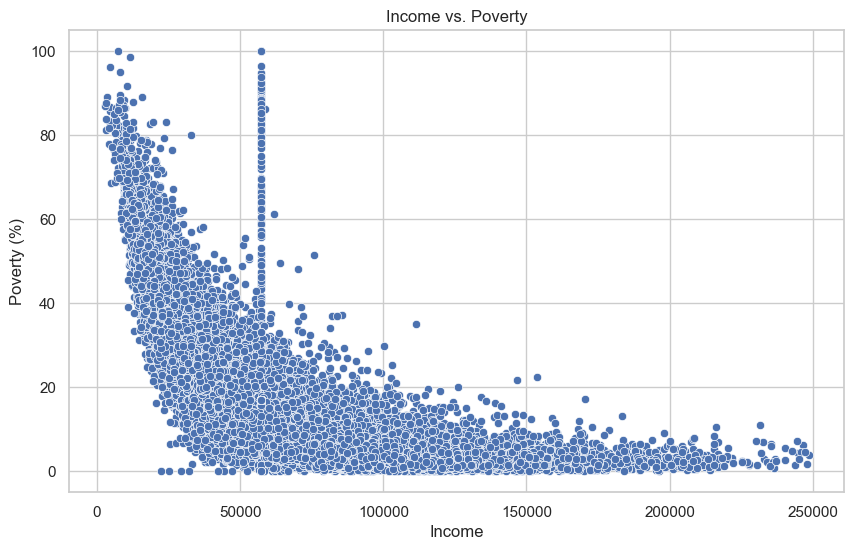

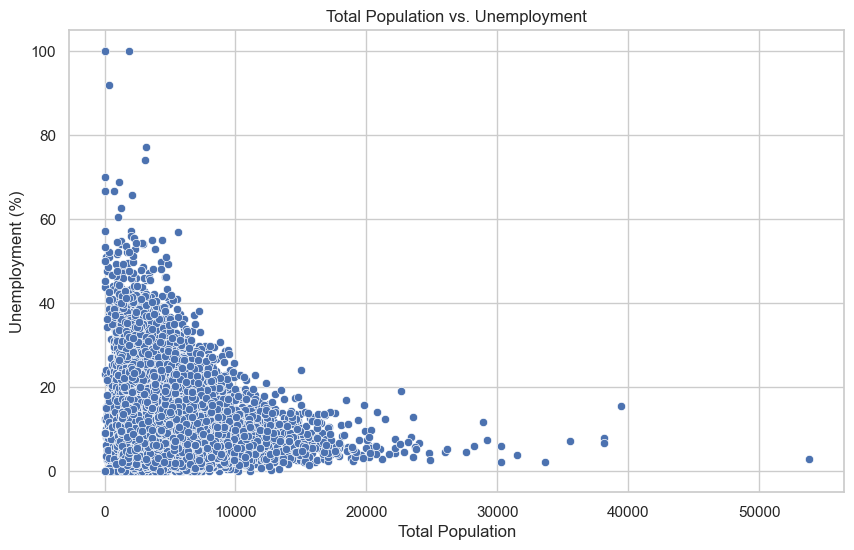

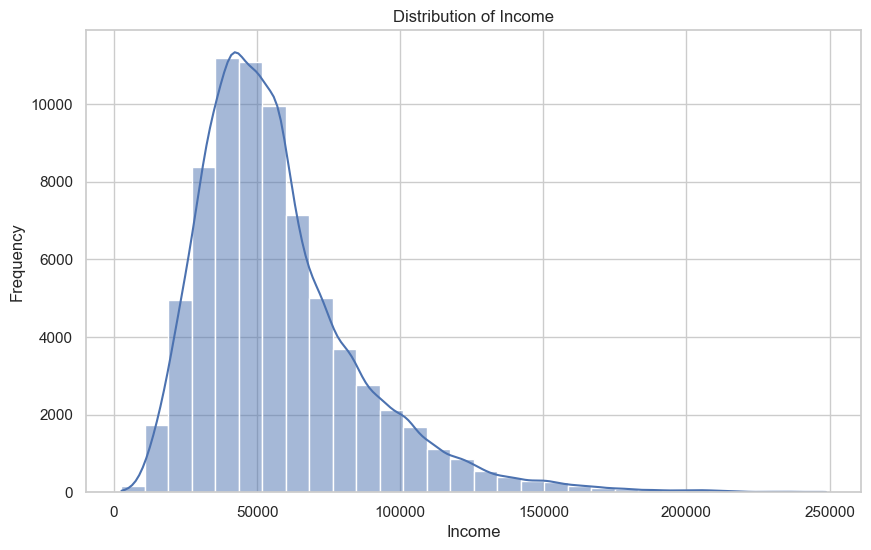

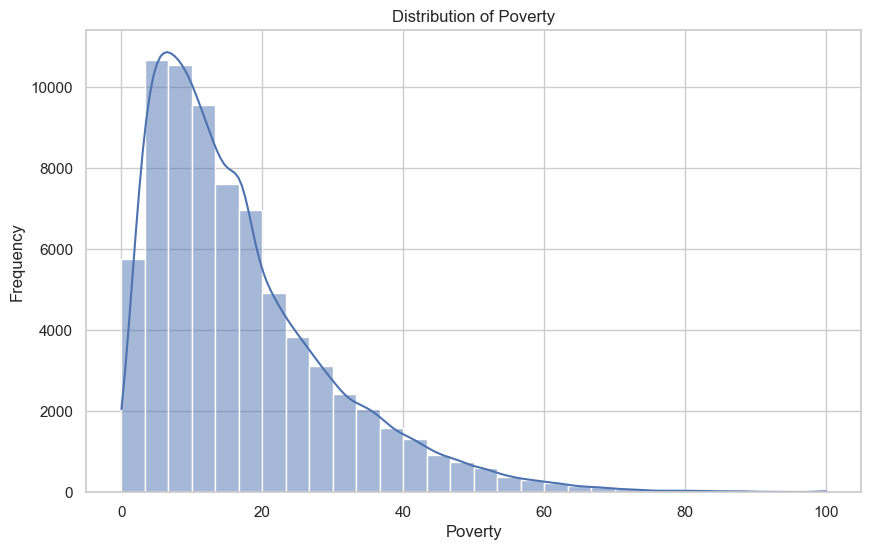

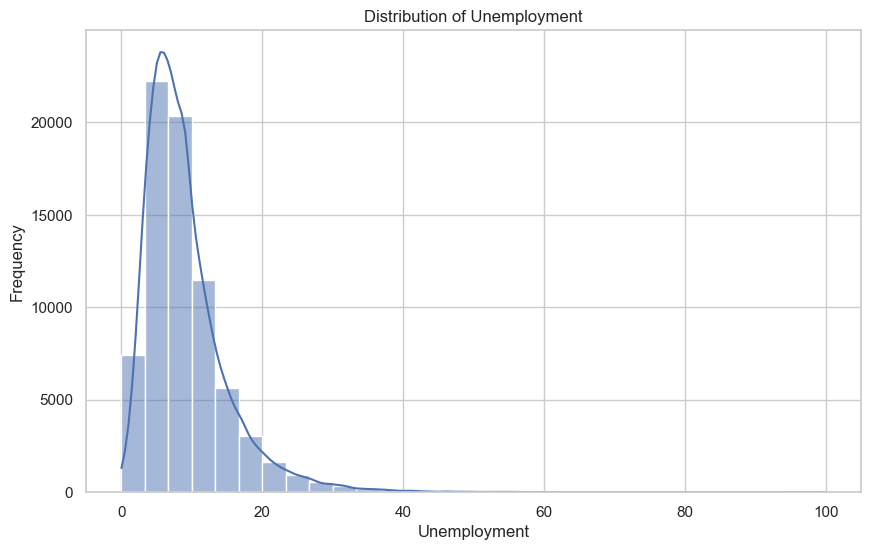

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Create a scatterplot for Income vs Poverty
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='Poverty', data=df)
plt.title('Income vs. Poverty')
plt.xlabel('Income')
plt.ylabel('Poverty (%)')
plt.show()

# Create a scatterplot for Unemployment vs TotalPop
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPop', y='Unemployment', data=df)
plt.title('Total Population vs. Unemployment')
plt.xlabel('Total Population')
plt.ylabel('Unemployment (%)')
plt.show()

# Create histograms for key columns
columns_to_plot = ['Income', 'Poverty', 'Unemployment']

# Plot histograms
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=30, kde=True)  # kde=True adds a density plot
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Interpretation

# Scatterplots:
# The first scatterplot shows the relationship between Income and Poverty. It helps identify patterns, correlations, or clusters.
# The second scatterplot visualizes the relationship between TotalPop and Unemployment.

# 1. Scatterplot: Income vs. Poverty

# Downward Trend: The scatterplot likely shows a negative correlation, where regions with higher incomes tend to have lower poverty rates. This aligns with the correlation matrix, which showed a strong negative relationship (-0.69) between these two variables.
# Clusters: You might observe clusters around the middle-income ranges, with poverty percentages concentrated in the lower ranges. Areas with very low incomes might show higher poverty rates, while areas with very high incomes will likely have near-zero poverty.
# Outliers: Look for outliers—regions where income is high but poverty is still high, or areas with low income but relatively low poverty. These outliers may represent unique socioeconomic situations.

# 2. Scatterplot: Total Population vs. Unemployment

# Weak Correlation: The correlation matrix showed a weak relationship between population size and unemployment (-0.12). So, in this scatterplot, there might not be a clear trend. The points are likely to be scattered across the plot without a strong pattern.
# Clusters: You may see a concentration of points around the average population size (roughly 4,000-5,000 people) and varying unemployment rates. Regions with very large or very small populations might stand out, but they might not necessarily correspond with high or low unemployment.
# Outliers: Some regions with exceptionally high populations could show up as outliers on the right side of the plot, and areas with very high or low unemployment could stand out vertically.

# 3. Histograms:

# Income:
# The histogram is likely right-skewed, with a large number of regions falling in the lower to middle-income brackets and a long tail extending toward higher incomes.
# The kde (kernel density estimate) overlay provides a smoother curve showing the probability density. The peak should be around the average income (~$57,225), with fewer regions as income increases.
# Outliers in income will appear in the long tail, where a few regions have extremely high incomes (close to the max of $248,750).

# Poverty:
# The histogram for poverty is also expected to be right-skewed, with many regions having low to moderate poverty rates and a long tail representing areas with high poverty.
# The kde curve will likely peak around the mean poverty rate (~17%) and taper off as poverty rates increase.
# High-poverty regions will be visible as outliers toward the right of the histogram (close to the max of 100%).

# Unemployment:
# Similar to the poverty distribution, the unemployment histogram should be right-skewed, with most regions having moderate unemployment rates (~9%), and a few regions showing very high unemployment.
# The kde curve will highlight the density of areas with moderate unemployment, while the tail represents regions with exceptionally high unemployment rates (close to 100%).

Summary Statistics:
               Income       Poverty  Unemployment      TotalPop
count   74001.000000  74001.000000  74001.000000  74001.000000
mean    57225.564862     16.958020      9.028663   4325.591465
std     28449.496049     13.121853      5.923081   2129.306903
min      2611.000000      0.000000      0.000000      0.000000
25%     37907.000000      7.300000      5.100000   2891.000000
50%     51466.000000     13.600000      7.700000   4063.000000
75%     69703.000000     23.000000     11.300000   5442.000000
max    248750.000000    100.000000    100.000000  53812.000000

Correlation Matrix:
                 Income   Poverty  Unemployment  TotalPop
Income        1.000000 -0.690492     -0.472229  0.170005
Poverty      -0.690492  1.000000      0.636283 -0.148585
Unemployment -0.472229  0.636283      1.000000 -0.123502
TotalPop      0.170005 -0.148585     -0.123502  1.000000

Number of unique States: 52, Number of unique Counties: 1928


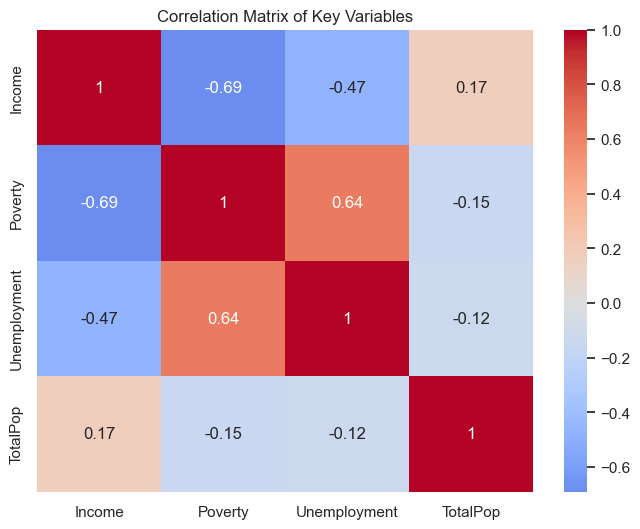

In [16]:
# Descriptive statistics of key columns
summary_stats = df[['Income', 'Poverty', 'Unemployment', 'TotalPop']].describe()
print("Summary Statistics:\n", summary_stats)

# Correlation matrix to check relationships between variables
correlation_matrix = df[['Income', 'Poverty', 'Unemployment', 'TotalPop']].corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

# Displaying the data types and checking for any unique values in categorical columns
unique_states = df['State'].nunique()
unique_counties = df['County'].nunique()
print(f"\nNumber of unique States: {unique_states}, Number of unique Counties: {unique_counties}")

# Additional code to visualize correlation heatmap for better understanding
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Variables')
plt.show()

In [ ]:
# Interpration

# Income:
# The average income is around $57,225 with a wide range (min: $2,611, max: $248,750).
# The standard deviation is high ($28,449), indicating that incomes vary significantly between areas. This variation could explain potential spread or clusters in the scatterplots.

# Poverty:
# The average poverty rate is 16.96%, with a wide spread from 0% to 100%. This shows there are areas with extreme poverty conditions, which could be visible as clusters of high poverty rates in the scatterplot.

# Unemployment:
# The average unemployment rate is 9.03%, with a large range from 0% to 100%. The large standard deviation suggests there are areas with extremely high unemployment, which might affect the distribution in the scatterplots and histograms.

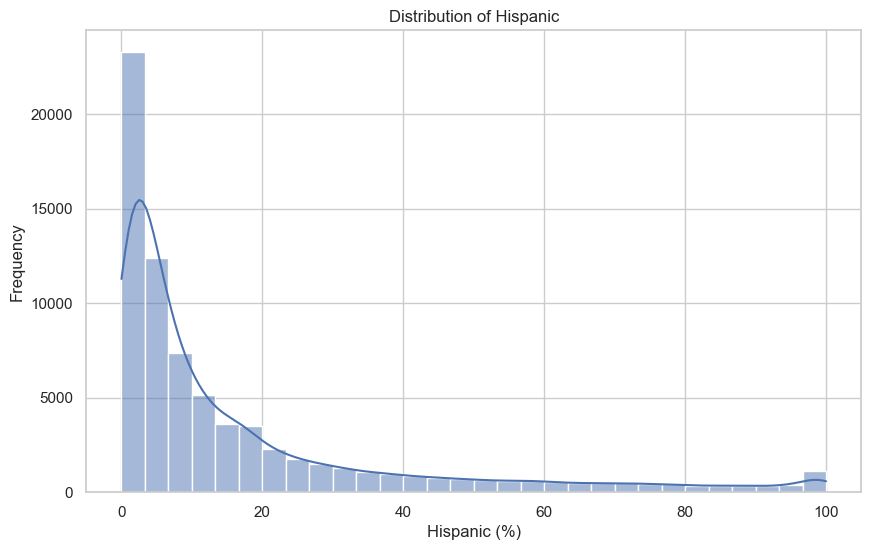

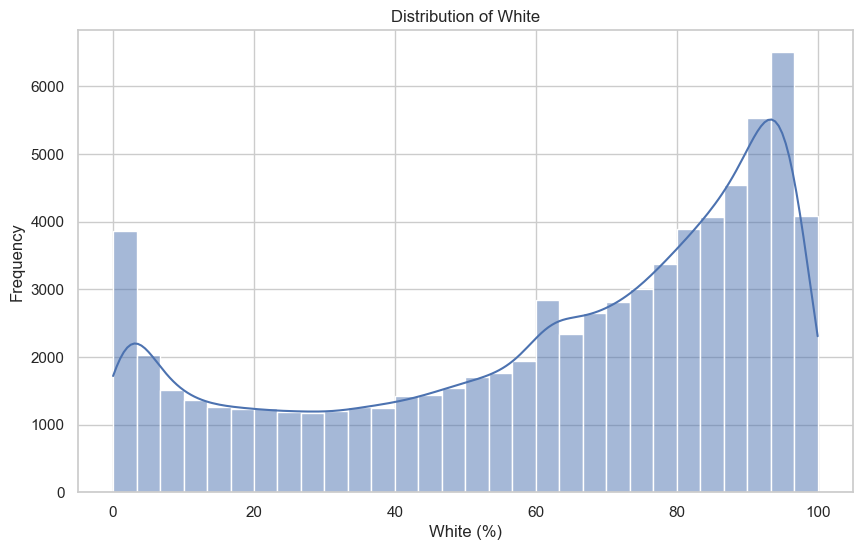

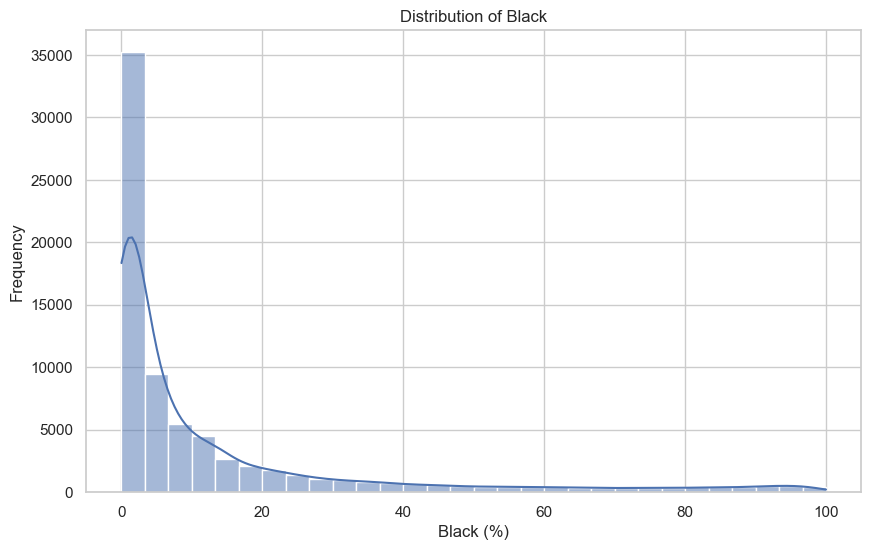

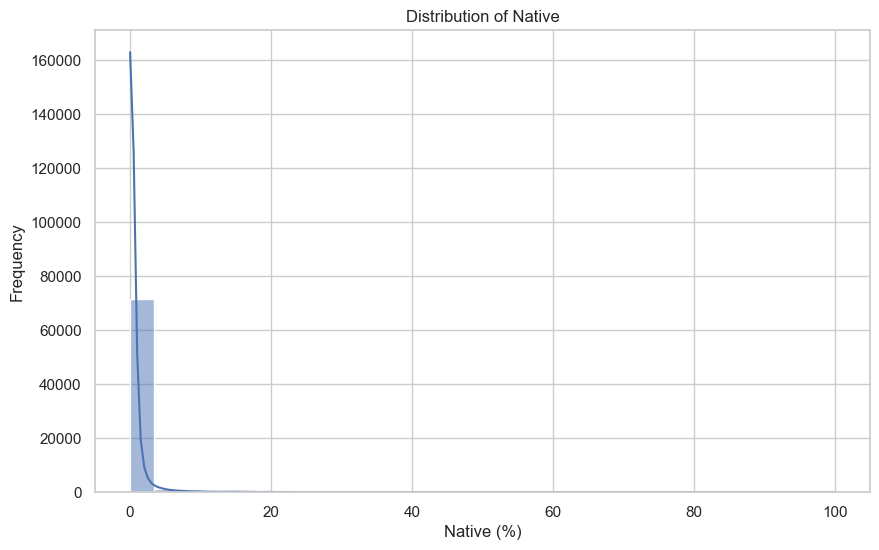

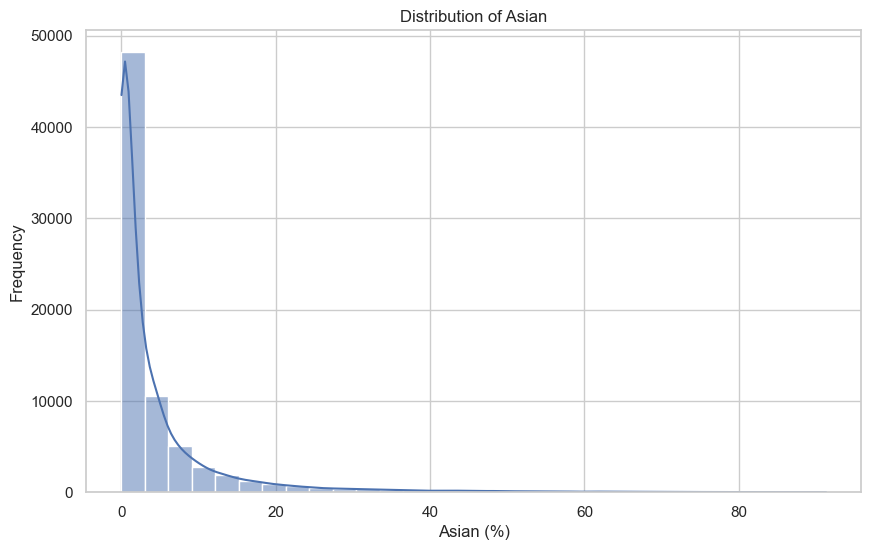

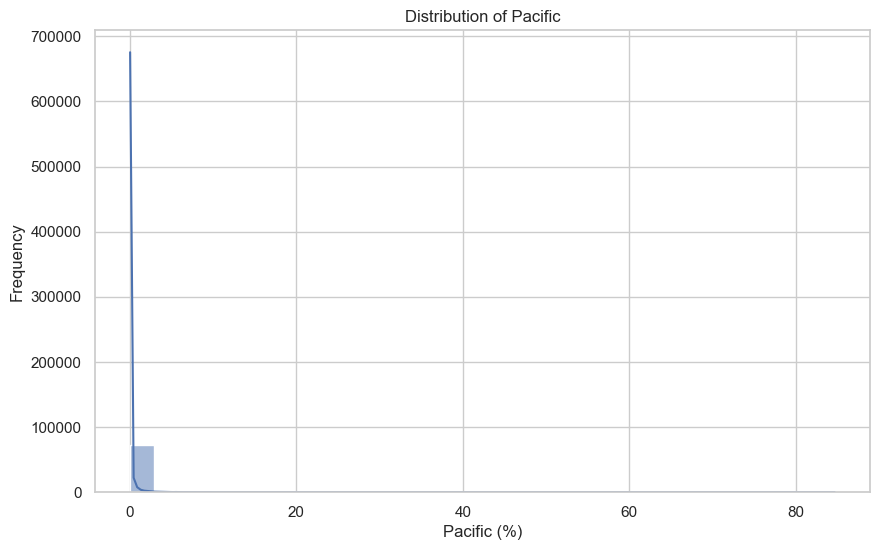

In [20]:
# Histograms for Racial/Ethnic Groups

# List of columns for racial/ethnic groups
race_columns = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

# Plot histograms for each racial/ethnic group
for column in race_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(f'{column} (%)')
    plt.ylabel('Frequency')
    plt.show()

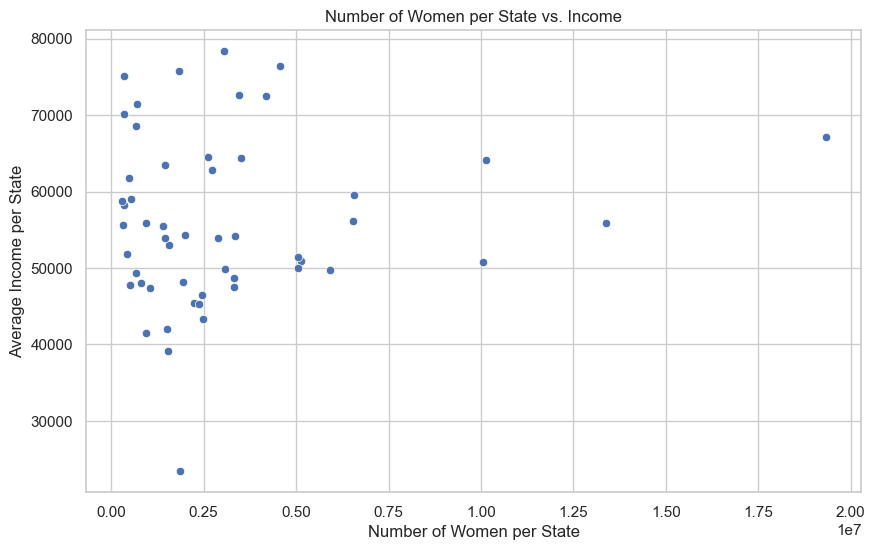

In [26]:
# Scatterplot: Income vs. Number of Women per State

# Group by State to get the total number of Women and average Income per State
state_agg = df.groupby('State').agg({
    'Women': 'sum',    # Total number of women per state
    'Income': 'mean'   # Average income per state
}).reset_index()

# Create scatterplot for Number of Women per State vs. Income (switched axes)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Women', y='Income', data=state_agg)
plt.title('Number of Women per State vs. Income')
plt.xlabel('Number of Women per State')
plt.ylabel('Average Income per State')
plt.show()